# Detección de Retinopatía Diabética

In [41]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.utils import class_weight
import sys
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential #Elaborar redes neuronales secuenciales
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation
from tensorflow.keras.layers import  Convolution2D, MaxPooling2D #Capas
from tensorflow.keras import backend as K #Empezar entrenamiento desde cero. Elimina cualquier rastro de modelos previamente compilados
from skimage import transform
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import load_model
from keras.metrics import Precision, Recall, F1Score, FBetaScore
from tensorflow.keras.callbacks import ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Input # Input Layer
from tensorflow.keras.applications import DenseNet121 # Keras Application
from tensorflow.keras.layers import Dense # Dense Layer (Fully connected)
from tensorflow.keras.models import Model # Model Structure

Directorio de datos e imágenes:

In [6]:
dir_data = '../data/raw/project_data.csv'
dir_images = '../data/raw/project_images'
dir_data2 = '../data/raw/project_data2.csv'
dir_images2 = '../data/raw/project_images2'

Creación del Dataframe:

In [7]:
data_df1 = pd.read_csv(dir_data)

data_df1['Id'] = data_df1['image'].str.split('_').str[0] # Crear la columna 'Id' dividiendo el nombre de la imagen

# Crear la columna 'path' concatenando el directorio de imágenes con el nombre de la imagen y la extensión '.jpeg'
data_df1['path'] = dir_images + '/' + data_df1['image'] + '.jpeg'
data_df1.rename(columns={'level': 'class'}, inplace=True)

# Verificar la existencia de las imágenes
data_df1['exists'] = data_df1['path'].map(os.path.exists)

#Elimina las filas que contienen nombres de imágenes que no están el el directorio images.
data_df1 = data_df1[data_df1['exists']]


In [8]:
data_df2 = pd.read_csv(dir_data2)

data_df2['Id'] = data_df2['id_code'].str.split('_').str[0] # Crear la columna 'Id' dividiendo el nombre de la imagen

# Crear la columna 'path' concatenando el directorio de imágenes con el nombre de la imagen y la extensión '.jpeg'
data_df2['path'] = dir_images2 + '/' + data_df2['id_code'] + '.png'
data_df2.rename(columns={'diagnosis': 'class'}, inplace=True)

# Verificar la existencia de las imágenes
data_df2['exists'] = data_df2['path'].map(os.path.exists)

#Elimina las filas que contienen nombres de imágenes que no están el el directorio images.
data_df2 = data_df2[data_df2['exists']]

Eliminación de los valores faltantes y mostrar el DataFrame 1 y 2:

In [9]:
data_df1.dropna(inplace = True)
data_df2.dropna(inplace =True)
data_df1.head()

,image,class,Id,path,exists
0,10_left,0,10,../data/raw/project_images/10_left.jpeg,True
1,10_right,0,10,../data/raw/project_images/10_right.jpeg,True
2,13_left,0,13,../data/raw/project_images/13_left.jpeg,True
3,13_right,0,13,../data/raw/project_images/13_right.jpeg,True
4,15_left,1,15,../data/raw/project_images/15_left.jpeg,True


In [10]:
data_df1.shape

(28269, 5)

In [11]:
data_df2.shape

(2646, 5)

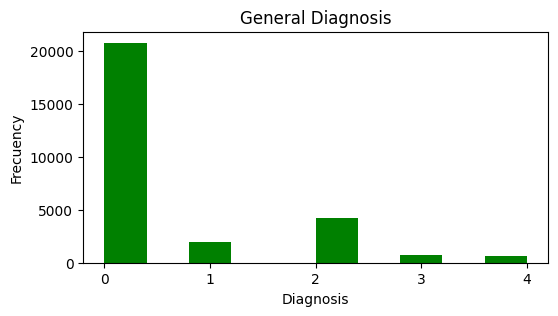

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(6, 3))

axs.hist(data_df1['class'], color='green')
axs.set_title('General Diagnosis')
axs.set_xlabel('Diagnosis')
axs.set_ylabel('Frecuency')
axs.set_xticks(data_df1['class'].unique())
plt.show()

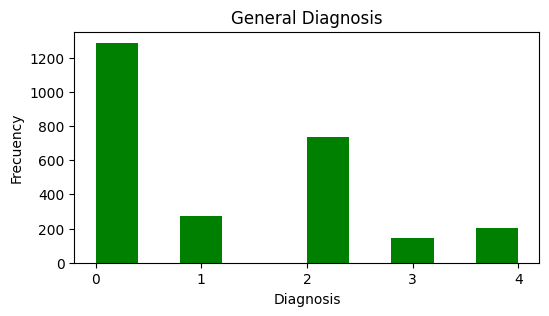

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(6, 3))

axs.hist(data_df2['class'], color='green')
axs.set_title('General Diagnosis')
axs.set_xlabel('Diagnosis')
axs.set_ylabel('Frecuency')
axs.set_xticks(data_df2['class'].unique())
plt.show()

En el gráfico se visualiza la preponderancia de la clase 0 frente a las demás clases

In [14]:
Frecuencia = data_df1['class'].value_counts()
Frecuencia

class
0    20791
2     4244
1     1913
3      732
4      589
Name: count, dtype: int64

In [15]:
Frecuencia = data_df2['class'].value_counts()
Frecuencia

class
0    1287
2     737
1     274
4     205
3     143
Name: count, dtype: int64

In [16]:
data_df1['class'] = data_df1['class'].replace([2, 3, 4], 1)
data_df1.head()

,image,class,Id,path,exists
0,10_left,0,10,../data/raw/project_images/10_left.jpeg,True
1,10_right,0,10,../data/raw/project_images/10_right.jpeg,True
2,13_left,0,13,../data/raw/project_images/13_left.jpeg,True
3,13_right,0,13,../data/raw/project_images/13_right.jpeg,True
4,15_left,1,15,../data/raw/project_images/15_left.jpeg,True


In [17]:
data_df2['class'] = data_df2['class'].replace([2, 3, 4], 1)
data_df2.head()

,id_code,class,Id,path,exists
0,000c1434d8d7,1,000c1434d8d7,../data/raw/project_images2/000c1434d8d7.png,True
1,001639a390f0,1,001639a390f0,../data/raw/project_images2/001639a390f0.png,True
2,0024cdab0c1e,1,0024cdab0c1e,../data/raw/project_images2/0024cdab0c1e.png,True
3,002c21358ce6,0,002c21358ce6,../data/raw/project_images2/002c21358ce6.png,True
4,005b95c28852,0,005b95c28852,../data/raw/project_images2/005b95c28852.png,True


In [18]:
Frecuencia = data_df2['class'].value_counts()
Frecuencia

class
1    1359
0    1287
Name: count, dtype: int64

In [19]:
data_df2= data_df2.loc[data_df2['class'] == 1]
data_df2.head()

,id_code,class,Id,path,exists
0,000c1434d8d7,1,000c1434d8d7,../data/raw/project_images2/000c1434d8d7.png,True
1,001639a390f0,1,001639a390f0,../data/raw/project_images2/001639a390f0.png,True
2,0024cdab0c1e,1,0024cdab0c1e,../data/raw/project_images2/0024cdab0c1e.png,True
5,0083ee8054ee,1,0083ee8054ee,../data/raw/project_images2/0083ee8054ee.png,True
7,00a8624548a9,1,00a8624548a9,../data/raw/project_images2/00a8624548a9.png,True


Juntar los dos dataframes

In [20]:
data_df = pd.concat([data_df1, data_df2], ignore_index=True)
Frecuencia = data_df['class'].value_counts()
Frecuencia

class
0    20791
1     8837
Name: count, dtype: int64

**División de las imágenes en train, test y val:**

In [21]:
from sklearn.model_selection import train_test_split

# Dividir los datos en train y temp (80% para train, 20% para temp)
train_data, temp_data = train_test_split(data_df, test_size=0.3, random_state=42, stratify=data_df['class'])

# Dividir temp_data en validation y test (50% para cada uno)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['class'])

# Imprimir los tamaños de los conjuntos resultantes
print("training images:", len(train_data))
print("Validation images:", len(val_data))
print("Test images:", len(test_data))

training images: 20739
Validation images: 4444
Test images: 4445


In [28]:
print(f'Datos de entrenamiento: {train_data['class'].value_counts()}')
print(f'Datos de validación: {test_data['class'].value_counts()}')
print(f'Datos de prueba: {val_data['class'].value_counts()}')

Datos de entrenamiento: class
0    14553
1     6186
Name: count, dtype: int64
Datos de validación: class
0    3119
1    1326
Name: count, dtype: int64
Datos de prueba: class
0    3119
1    1325
Name: count, dtype: int64


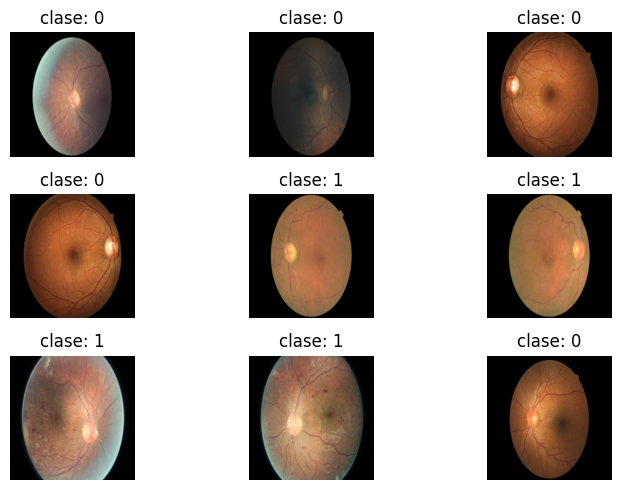

In [33]:
eyes_images = []
levels = []

for i in range(9):
    imag_path = data_df["path"].iloc[i]
    level = data_df["class"].iloc[i]
    levels.append(level)
    #Utilizamos la Librería PIL (pillow) para abrir y reajstar las imágenes
    img = Image.open(imag_path)
    img = img.resize((200, 200))
    #Normalización de las imágenes [0-1]
    img_array = np.array(img) / 255.0
    eyes_images.append(img_array)

plt.figure(figsize=(8, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(eyes_images[i])
    plt.title(f'clase: {levels[i]}')
    plt.axis('off')

plt.tight_layout()

plt.show()

Filtrado de imágenes dañadas:

In [37]:
'''def is_valid_image(file_path):
    try:
        # Abre la imagen y verifica si es válida
        img = Image.open(file_path)
        img.load()
        return True
    except (OSError, IOError) as e:
        print(f'Error al cargar la imagen: {file_path}')
        return False

# Filtra los datos de entrenamiento para mantener solo las imágenes válidas
train_data1 = train_df[train_df['path'].apply(is_valid_image)]

# Filtra los datos de validación para mantener solo las imágenes válidas
val_data1 = val_data[val_data['path'].apply(is_valid_image)]

test_data1 = test_data[test_data['path'].apply(is_valid_image)]
'''

"def is_valid_image(file_path):\n    try:\n        # Abre la imagen y verifica si es válida\n        img = Image.open(file_path)\n        img.load()\n        return True\n    except (OSError, IOError) as e:\n        print(f'Error al cargar la imagen: {file_path}')\n        return False\n\n# Filtra los datos de entrenamiento para mantener solo las imágenes válidas\ntrain_data1 = train_df[train_df['path'].apply(is_valid_image)]\n\n# Filtra los datos de validación para mantener solo las imágenes válidas\nval_data1 = val_data[val_data['path'].apply(is_valid_image)]\n\ntest_data1 = test_data[test_data['path'].apply(is_valid_image)]\n"

*Preprocesamiento de las imágenes:

In [34]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
def load_ben_color(image):
    sigmaX=50
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (224, 224
                               ))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)

    return image

Data Generator:

In [35]:
K.clear_session()

train_data['class'] = train_data['class'].astype(str)
val_data['class'] = val_data['class'].astype(str)
test_data['class'] = test_data['class'].astype(str)


"""
Parameters
"""
epocas=1
longitud, altura = 224, 224
batch_size = 32
pasos = 500
validation_steps = 300
filtrosConv1 = 32
filtrosConv2 = 64
tamano_filtro1 = (3, 3)
tamano_filtro2 = (2, 2)
tamano_pool = (2, 2)
clases = 2
lr = 0.0004


datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    preprocessing_function=load_ben_color, 

)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_dataframe(
    train_data,
    x_col='path',
    y_col='class',
    color_mode='rgb',
    target_size=(longitud, altura),  # Reescalar imágenes a 224x224 píxeles
    batch_size=32,
    class_mode='binary'
)

val_generator = datagen.flow_from_dataframe(
    val_data,
    x_col = 'path',
    y_col = 'class',
    color_mode = 'rgb',
    target_size=(longitud, altura),  # Reescalar imágenes a 200x200 píxeles
    batch_size=32,
    class_mode = 'binary')


test_generator= datagen.flow_from_dataframe(
    test_data,
    x_col = "path",
    y_col = "class" ,
    color_mode = 'rgb',
    target_size=(longitud, altura),  # Reescalar imágenes a 200x200 píxeles
    batch_size=32,
    class_mode = 'binary')


Found 20739 validated image filenames belonging to 2 classes.
Found 4444 validated image filenames belonging to 2 classes.
Found 4445 validated image filenames belonging to 2 classes.


Visualización de las cinco primeras imágenes del generador de entrenamiento:


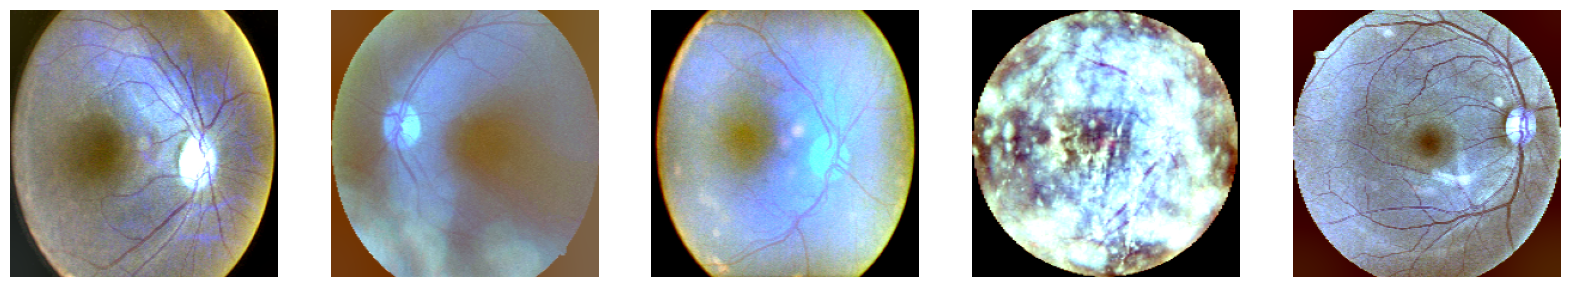

In [39]:
print("Visualización de las cinco primeras imágenes del generador de entrenamiento:")
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    batch = next(train_generator)
    image = batch[0][0]  # la primera imagen del lote
    image = np.clip(image, 0, 1)  # Limitar los valores de píxeles al rango [0, 1]
    ax[i].imshow(image)
    ax[i].axis('off')
plt.show()

*Cálculo de los pesos para compensar el desbalance de clase de las imágenes:

In [42]:
# Calcular los pesos de clase inversamente proporcionales a las frecuencias de clase
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data['class']), y=train_data['class'])


# Convertir los pesos de clase en un diccionario
class_weight_dict = dict(zip(np.unique(train_data['class']), class_weights))

class_weight_dict

{'0': 0.712533498247784, '1': 1.6762851600387974}

*Creación del modelo usando DenseNet121

In [186]:
input_shape=(224, 224, 3)

img_input = Input(shape=input_shape)
base_model = DenseNet121(include_top=False, 
                         input_tensor=img_input, 
                         input_shape=input_shape, 
                         pooling="max"
                         )
base_model.trainable = True

# Añadir la capa de salida para clasificación binaria
x = base_model.output
predictions = Dense(1, 
                    activation="sigmoid", 
                    name="predictions")(x)
model = Model(inputs=img_input, 
              outputs=predictions)

Métricas del modelo:

In [119]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #by default learning_rate=0.001
    loss='binary_crossentropy',
    metrics=['accuracy', Recall(), Precision()]
)

Callbacks:

In [188]:
checkpoint = ModelCheckpoint("../models/retinas.keras",
                            monitor="val_accuracy",  # La métrica que se va a monitorear para decidir si guardar o no el modelo.
                            verbose=2,  # El nivel de detalle de los mensajes que se mostrarán durante el proceso de guardado del modelo
                            save_best_only=True,  # si se deben guardar solo los pesos del modelo que resulten en la mejor puntuación de la métrica monitoreada
                            save_weights_only=False, # si se deben guardar solo los pesos del modelo (True) o el modelo completo (False)
                            mode="auto",  # Especifica si se debe maximizar ('max') o minimizar ('min') la métrica monitorizada
                            save_freq="epoch")  # Especifica la frecuencia con la que se debe guardar el modelo

In [189]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # métrica que se va a monitorear para decidir si se debe reducir la tasa de aprendizaje."val_loss" para la pérdida en el conjunto de validación
                              factor=0.01, # Factor por el cual se reducirá la tasa de aprendizaje. Después de que se activa la reducción de la tasa de aprendizaje, la nueva tasa será learning_rate = learning_rate * factor.
                              patience=2,  # Número de épocas sin mejora después del cual se reducirá la tasa de aprendizaje
                              verbose = 1,
                              mode = 'auto',
                              min_lr=0.00001)

In [191]:
early_stopping = EarlyStopping(monitor='val_recall', 
                               mode='max', 
                               verbose=1, 
                               patience=2, 
                               restore_best_weights=True)

Entrenamiento del modelo:

In [124]:
batch_size = 64

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=12,
    validation_data=val_generator,
    validation_steps=len(val_data) // batch_size,
    callbacks=[checkpoint, reduce_lr, early_stopping],
    class_weight = class_weight_dict
    )

model.save('../models/densenet121_model.h5')

Epoch 1/12


c:\Users\crroj\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6531 - loss: 1.0513 - precision: 0.4532 - recall: 0.4938
Epoch 1: val_accuracy improved from -inf to 0.75951, saving model to ../models/retinas.keras
324/324 ━━━━━━━━━━━━━━━━━━━━ 2907s 9s/step - accuracy: 0.6533 - loss: 1.0505 - precision: 0.4534 - recall: 0.4938 - val_accuracy: 0.7595 - val_loss: 0.7662 - val_precision: 0.7454 - val_recall: 0.3042 - learning_rate: 1.0000e-04
Epoch 2/12
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7565 - loss: 0.5782 - precision: 0.5991 - recall: 0.4931
Epoch 2: val_accuracy improved from 0.75951 to 0.77989, saving model to ../models/retinas.keras
324/324 ━━━━━━━━━━━━━━━━━━━━ 2911s 9s/step - accuracy: 0.7565 - loss: 0.5781 - precision: 0.5992 - recall: 0.4931 - val_accuracy: 0.7799 - val_loss: 0.6496 - val_precision: 0.7739 - val_recall: 0.3956 - learning_rate: 1.0000e-04
Epoch 3/12
  1/324 ━━━━━━━━━━━━━━━━━━━━ 29:20 5s/step - accuracy: 0.8438 - loss: 0.5326 - precision: 0.7500 - recall: 0.

c:\Users\crroj\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 3: val_accuracy improved from 0.77989 to 0.82143, saving model to ../models/retinas.keras
324/324 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.8438 - loss: 0.5326 - precision: 0.7500 - recall: 0.6667 - val_accuracy: 0.8214 - val_loss: 0.5988 - val_precision: 0.7500 - val_recall: 0.4286 - learning_rate: 1.0000e-04
Epoch 4/12
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7952 - loss: 0.4836 - precision: 0.6858 - recall: 0.5548
Epoch 4: val_accuracy did not improve from 0.82143
324/324 ━━━━━━━━━━━━━━━━━━━━ 3015s 9s/step - accuracy: 0.7952 - loss: 0.4836 - precision: 0.6858 - recall: 0.5548 - val_accuracy: 0.7930 - val_loss: 0.5504 - val_precision: 0.7663 - val_recall: 0.4559 - learning_rate: 1.0000e-04
Epoch 5/12
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8170 - loss: 0.4231 - precision: 0.7311 - recall: 0.5926
Epoch 5: val_accuracy did not improve from 0.82143
324/324 ━━━━━━━━━━━━━━━━━━━━ 2910s 9s/step - accuracy: 0.8170 - loss: 0.4231 - precision: 0.7310 - 

Guardar el modelo en .h5:

In [125]:
model.save_weights('../models/pesos_entrenados.weights.h5')

In [43]:
modelo = load_model('../models/densenet121_model.h5')
modelo.load_weights('../models/pesos_entrenados.weights.h5')



# Aplicar clases ponderadas durante la predicción
#predictions = modelo.predict(test_generator, verbose=1)

c:\Users\crroj\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 730 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [152]:
modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #by default learning_rate=0.001
    loss='binary_crossentropy',
    metrics=['accuracy', Recall(), Precision()]
)

In [153]:
batch_size = 64

history = modelo.fit(
    train_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=8,
    validation_data=val_generator,
    validation_steps=len(val_data) // batch_size,
    callbacks=[checkpoint, reduce_lr, early_stopping],
    class_weight = class_weight_dict
    )

modelo.save('../models/densenet121_model2.h5')

Epoch 1/8


c:\Users\crroj\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8377 - loss: 0.3733 - precision: 0.7685 - recall: 0.6565
Epoch 1: val_accuracy improved from -inf to 0.75996, saving model to ../models/retinas.keras
324/324 ━━━━━━━━━━━━━━━━━━━━ 2075s 6s/step - accuracy: 0.8377 - loss: 0.3733 - precision: 0.7685 - recall: 0.6564 - val_accuracy: 0.7600 - val_loss: 0.5266 - val_precision: 0.6008 - val_recall: 0.6470 - learning_rate: 1.0000e-04
Epoch 2/8
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8498 - loss: 0.3627 - precision: 0.8015 - recall: 0.6614
Epoch 2: val_accuracy improved from 0.75996 to 0.77853, saving model to ../models/retinas.keras
324/324 ━━━━━━━━━━━━━━━━━━━━ 1973s 6s/step - accuracy: 0.8498 - loss: 0.3627 - precision: 0.8014 - recall: 0.6615 - val_accuracy: 0.7785 - val_loss: 0.5338 - val_precision: 0.6418 - val_recall: 0.6237 - learning_rate: 1.0000e-04
Epoch 3/8
  1/324 ━━━━━━━━━━━━━━━━━━━━ 28:41 5s/step - accuracy: 0.8438 - loss: 0.3170 - precision: 0.8000 - recall: 0.72

c:\Users\crroj\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 3: val_accuracy did not improve from 0.77853
324/324 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8438 - loss: 0.3170 - precision: 0.8000 - recall: 0.7273 - val_accuracy: 0.7500 - val_loss: 0.4529 - val_precision: 0.3333 - val_recall: 0.4000 - learning_rate: 1.0000e-04
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


In [50]:
predictions = modelo.predict(test_generator)
df_pred = pd.DataFrame(predictions)
df_pred.to_csv('../data/processed/test_predictions.csv', index=False)

139/139 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step


In [ ]:
evaluated_model = modelo.evaluate(test_generator)

